# Technical Exercise – Data Scientist

Tasks:
1.	Which factors best predict anti-social behaviour? -> multivariate regression problem -> Feature Selection -> Random Forest Regression,Linear Regression (PyCarret AutoML) <br><br>
2.	Data were missing for the St. John’s ward in Woking due to a recording error. Given what we know about the demographics of this area, can you predict the level of anti-social behaviour it might experience? -> Imputation Techniques, Domain Knowledge & Similar Ward Analysis <br><br>



In [1]:
## python 3.11
# !pip install -q pycaret
# !pip install -q sktime[all_extras]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pycaret.regression import *

## Data

In [3]:
n=3
df_indecators = pd.read_csv('data/indicators.csv')
df_geo = pd.read_excel(
  'data/LSOA 2021 to Ward 2022 to LA 2022 lookup England and Wales.xlsx')
df_street_crime = pd.read_excel('data/Surrey_street_crime.xlsx')
print('indecators')
display(df_indecators.head(n))
print(df_indecators.shape)
print('geos')
display(df_geo.head(n))
print(df_geo.shape)
print('Sterrt crime')
display(df_street_crime.head(n))
print(df_street_crime.shape)

indecators


,Area Type,Area Name,Unemployment benefit (JSA and Universal Credit) (Sep 2023),Disability benefit (Feb 2023),Pensioners in poverty (Pension Credit),Youth unemployment (18-24 receiving JSA or Universal Credit) (Sep 2023),Percentage of children in poverty (after housing costs),Total population (2020),Population aged 0-15 (2020),Population of working age (16-64) (2020),...,Children 0-19 in relative low-income out of work families (as % of all in relative low income families) (2021/2022),Children 0-19 in relative low-income in-work families (as % of all in relative low income families) (2021/2022),Children aged 0-19 in relative low-income families (2021/2022),Households with no car (Census 2021),Broadband speed (July 2020),Premises with broadband speeds below the Universal Service Obligation (USO) (2019),"Greenspace coverage, public parks and gardens (2017)","Greenspace coverage, total (2017)","Voter Turnout at Local Elections (2016-2019, depending on when the Local Council held their most recent election)",Households in Fuel Poverty (2021)
0,County,Surrey,2.158800,1.551332,6.090448,2.654761,19.637423,1199872,19.745940,61.093683,...,16.225847,83.759459,9.341381,12.714035,78.051656,0.725177,1.767591,6.179592,35.315675,7.347314
1,Elmbridge Wards,Claygate,1.977967,0.998146,5.183727,0.000000,16.671953,7013,21.317553,56.951376,...,14.606742,NaN,4.944444,9.356101,92.168959,0.000000,0.003211,3.814245,41.556777,7.654666
2,Elmbridge Wards,Cobham and Downside,1.983114,1.503926,7.779419,2.296451,32.096514,9043,21.220834,56.319805,...,15.311005,NaN,9.067245,12.506724,79.493225,0.517879,2.373987,3.116821,30.212631,9.071674


(199, 66)
geos


,LSOA21CD,LSOA21NM,LSOA21NMW,WD22CD,WD22NM,WD22NMW,LAD22CD,LAD22NM,LAD22NMW,ObjectId
0,E01004766,Bolton 005A,NaN,E05000650,Astley Bridge,NaN,E08000001,Bolton,NaN,1
1,E01005347,Oldham 028E,NaN,E05000722,Chadderton South,NaN,E08000004,Oldham,NaN,2
2,E01004890,Bolton 004E,NaN,E05000661,Horwich North East,NaN,E08000001,Bolton,NaN,3


(35672, 10)
Sterrt crime


,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Borough name,Crime type,Last outcome category,Context
0,8720eda20c741d07c0517f413ac9f87bdc7eceaa585f1b...,2020-10-01,Surrey Police,Surrey Police,0.107482,51.427084,On or near St John'S Road,E01000459,Bexley 027F,Bexley,Violence and sexual offences,Unable to prosecute suspect,NaN
1,NaN,2020-10-01,Surrey Police,Surrey Police,-0.774968,51.332407,On or near Station Approach,E01016196,Bracknell Forest 015B,Bracknell Forest,Anti-social behaviour,NaN,NaN
2,b78b8b4c93252c02f252b8255ed49e4cf240ffe1a0b568...,2020-10-01,Surrey Police,Surrey Police,-0.774968,51.332407,On or near Station Approach,E01016196,Bracknell Forest 015B,Bracknell Forest,Drugs,Offender given a caution,NaN


(266265, 13)


In [4]:
# Convert all categorical fields to lowercase
df_indecators = df_indecators.applymap(lambda x: x.lower().strip() if isinstance(x, str) else x)
df_geo = df_geo.applymap(lambda x: x.lower().strip() if isinstance(x, str) else x)
df_street_crime = df_street_crime.applymap(lambda x: x.lower().strip() if isinstance(x, str) else x)

### Perpare data

#### Indicators dataset

In [5]:
# Shortening columns names for easier handling
new_names = {
  "Area Type": "AreaType",
  "Area Name": "AreaName",
  "Unemployment benefit (JSA and Universal Credit) (Sep 2023)": "UnempBenefitSep23",
  "Disability benefit (Feb 2023)": "DisabilityBenefitFeb23",
  "Pensioners in poverty (Pension Credit)": "PensionersPoverty",
  "Youth unemployment (18-24 receiving JSA or Universal Credit) (Sep 2023)": "YouthUnempSep23",
  "Percentage of children in poverty (after housing costs)": "ChildPovertyPct",
  "Total population (2020)": "TotalPop2020",
  "Population aged 0-15 (2020)": "Pop0to15_2020",
  "Population of working age (16-64) (2020)": "WorkingAgePop2020",
  "Population aged 65+ (2020)": "Pop65plus_2020",
  "White ethnic groups (Census 2021)": "WhiteEthnic2021",
  "Mixed ethnic groups (Census 2021)": "MixedEthnic2021",
  "Asian ethnic groups (Census 2021)": "AsianEthnic2021",
  "Black ethnic groups (Census 2021)": "BlackEthnic2021",
  "Arab ethnic group (Census 2021)": "ArabEthnic2021",
  "Other ethnic group (Census 2021)": "OtherEthnic2021",
  "Non-white ethnic group (Census 2021)": "NonWhiteEthnic2021",
  "Migrants (Census 2021)": "Migrants2021",
  "Lone parent households with dependent children (Census 2021)": "LoneParentHouseholds2021",
  "Population density (persons per hectare) (2020)": "PopDensity2020",
  "No people in household have English as a main language (Census 2021)": "NonEnglishHouseholds2021",
  "All householders (aged 16+) have English as a main language (Census 2021)": "EnglishHouseholders2021",
  "Owner occupied housing (Census 2021)": "OwnerHousing2021",
  "Social rented housing (Census 2021)": "SocialRented2021",
  "Private rented housing (Census 2021)": "PrivateRented2021",
  "Overcrowded housing (Census 2021)": "OvercrowdedHousing2021",
  "Average house price (June 2022 - May 2023)": "AvgHousePriceJun22May23",
  "Vacant Dwellings (Census 2011)": "VacantDwellings2011",
  "Median house price (Sept 2022)": "MedianHousePriceSep22",
  "Housing affordability: Total price/salary ratio (average house) (Year ending Sep 2017 House Prices, 2015/16 Earnings)": "HousingAffordabilityRatio",
  "Average household size (Census 2011)": "AvgHouseholdSize2011",
  "Total crime offences (June-22 to May-23)": "TotalCrimeOffencesJun22May23",
  "Female life expectancy at birth (2016-2020)": "FemaleLifeExp2016to2020",
  "Male life expectancy at birth (2016-2020)": "MaleLifeExp2016to2020",
  "Adults who are physically active (modelled MSOA estimates) (2018/19)": "ActiveAdults201819",
  "Obese children in year 6 (2019/20 - 21/22)": "ObeseChildrenY62019202122",
  "Obese adults (2006-2008)": "ObeseAdults20062008",
  "Economically active (Census 2021)": "EconomicallyActive2021",
  "Economically inactive (Census 2021)": "EconomicallyInactive2021",
  "Economically active: Full-time student (Census 2021)": "ActiveFullTimeStudent2021",
  "Economically active: Unemployed (Census 2021)": "ActiveUnemployed2021",
  "Economically inactive: Long-term sick or disabled (Census 2021)": "InactiveLongTermSickDisabled2021",
  "Economically inactive: Student (including full-time students) (Census 2021)": "InactiveStudent2021",
  "Economically inactive: Retired (Census 2021)": "InactiveRetired2021",
  "Economically inactive: Other (Census 2021)": "InactiveOther2021",
  "Unemployment to available jobs ratio (Nov-12)": "UnempToJobsRatioNov12",
  "Total annual household income estimate (2017/18)": "TotalAnnualIncome1718",
  "Net annual household income estimate after housing costs (2017/18)": "NetAnnualIncomeAfterHousing1718",
  "Proportion of households on Universal Credit (May-23)": "UniversalCreditProportionMay23",
  "People with no qualifications (Census 2021)": "NoQualifications2021",
  "Highest level of qualification: Level 4/5 (degree or higher) qualifications (Census 2021)": "HighQualifications2021",
  "Index of Multiple Deprivation (IMD) 2019 Rank": "IMD2019Rank",
  "Index of Multiple Deprivation 2019 (IMD) Score": "IMD2019Score",
  "Children 0-19 in relative low-income couple families (as % of all in relative low income families) (2021/2022)": "ChildLowIncomeCouplePct202122",
  "Children 0-19 in relative low-income lone parent families (as % of all in relative low income families) (2021/2022)": "ChildLowIncomeLoneParentPct202122",
  "Children 0-19 in relative low-income out of work families (as % of all in relative low income families) (2021/2022)": "ChildLowIncomeOutOfWorkPct202122",
  "Children 0-19 in relative low-income in-work families (as % of all in relative low income families) (2021/2022)": "ChildLowIncomeInWorkPct202122",
  "Children aged 0-19 in relative low-income families (2021/2022)": "ChildLowIncomeFamilies202122",
  "Households with no car (Census 2021)": "NoCarHouseholds2021",
  "Broadband speed (July 2020)": "BroadbandSpeedJul20",
  "Premises with broadband speeds below the Universal Service Obligation (USO) (2019)": "BelowUSOBroadbandPremises2019",
  "Greenspace coverage, public parks and gardens (2017)": "GreenspacePublicParks2017",
  "Greenspace coverage, total (2017)": "GreenspaceTotal2017",
  "Voter Turnout at Local Elections (2016-2019, depending on when the Local Council held their most recent election)": "LocalElectionVoterTurnout2016to2019",
  "Households in Fuel Poverty (2021)": "FuelPovertyHouseholds2021"
}

In [6]:
df_indecators = df_indecators.rename(columns=new_names)

In [7]:
df_indecators[df_indecators['AreaName']=="st john's"]

,AreaType,AreaName,UnempBenefitSep23,DisabilityBenefitFeb23,PensionersPoverty,YouthUnempSep23,ChildPovertyPct,TotalPop2020,Pop0to15_2020,WorkingAgePop2020,...,ChildLowIncomeOutOfWorkPct202122,ChildLowIncomeInWorkPct202122,ChildLowIncomeFamilies202122,NoCarHouseholds2021,BroadbandSpeedJul20,BelowUSOBroadbandPremises2019,GreenspacePublicParks2017,GreenspaceTotal2017,LocalElectionVoterTurnout2016to2019,FuelPovertyHouseholds2021
198,woking wards,st john's,2.58894,1.876759,6.370757,5.434783,19.093074,9591,20.83203,59.201335,...,6.629834,NaN,7.662997,14.413543,98.104419,0.0,1.747096,1.896225,37.866667,5.691809


##### Identify the features from the indicators dataset

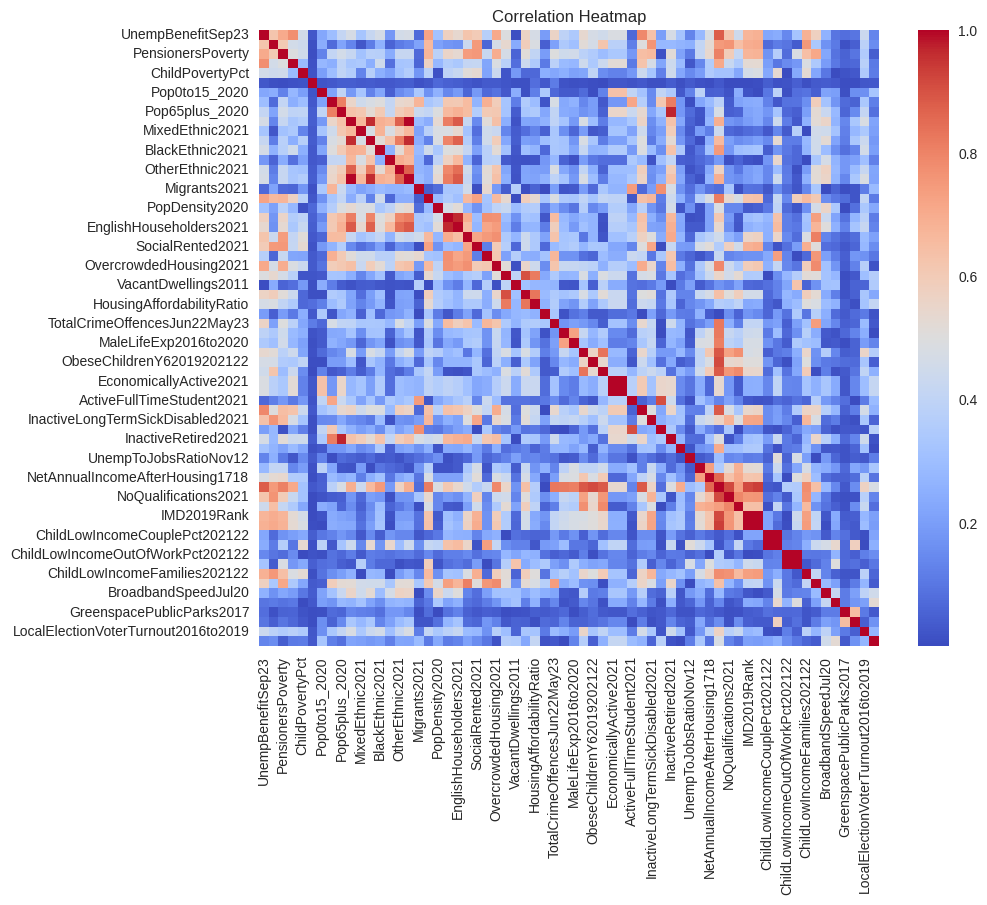

In [8]:
df_indecators_clean = df_indecators[df_indecators['AreaName'].notnull()] # Remove rows with no area name

# perform peareon auto correlation
features = df_indecators_clean.select_dtypes(include='number')
correlation_matrix = features.corr().abs()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

It's clear that some features have high autocorrelation, so this should be addressed in preprocessing by selecting less correlated features not to affect the model performance.

In [9]:
threshold = 0.8 # correlation threshold
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(np.bool_))
highly_correlated = [column for column in upper.columns if any(upper[column] > threshold)]
features_from_eval = ['TotalCrimeOffencesJun22May23', 'OwnerHousing2021'] # include highly corrolated featuers with the target
highly_correlated.extend(features_from_eval)
non_correlated_features = [column for column in df_indecators_clean.columns if column not in highly_correlated]
print("Count of all fetaures: ",len(features.columns))
print("Count of non corrolated features: ",len(non_correlated_features))

Count of all fetaures:  64
Count of non corrolated features:  45


In [10]:
# df_indecators_clean = df_indecators_clean[non_correlated_features]
df_indecators_clean = df_indecators_clean[df_indecators_clean['AreaType']!='county'].reset_index(drop=True) # Remove rows with county area type
display(df_indecators_clean.head(n))

,AreaType,AreaName,UnempBenefitSep23,DisabilityBenefitFeb23,PensionersPoverty,YouthUnempSep23,ChildPovertyPct,TotalPop2020,Pop0to15_2020,WorkingAgePop2020,...,ChildLowIncomeOutOfWorkPct202122,ChildLowIncomeInWorkPct202122,ChildLowIncomeFamilies202122,NoCarHouseholds2021,BroadbandSpeedJul20,BelowUSOBroadbandPremises2019,GreenspacePublicParks2017,GreenspaceTotal2017,LocalElectionVoterTurnout2016to2019,FuelPovertyHouseholds2021
0,elmbridge wards,claygate,1.977967,0.998146,5.183727,0.000000,16.671953,7013,21.317553,56.951376,...,14.606742,NaN,4.944444,9.356101,92.168959,0.000000,0.003211,3.814245,41.556777,7.654666
1,elmbridge wards,cobham and downside,1.983114,1.503926,7.779419,2.296451,32.096514,9043,21.220834,56.319805,...,15.311005,NaN,9.067245,12.506724,79.493225,0.517879,2.373987,3.116821,30.212631,9.071674
2,elmbridge wards,esher,2.075204,1.307190,5.772402,2.622951,24.072676,9486,21.389416,59.434957,...,15.950920,NaN,6.546185,9.899610,85.752733,0.406814,2.266658,9.905930,37.557746,8.028017


In [11]:
# check for missing values
df_indecators_clean.isna().sum().sort_values(ascending=False)

ChildLowIncomeInWorkPct202122        187
UniversalCreditProportionMay23       187
ChildLowIncomeLoneParentPct202122    187
ChildLowIncomeOutOfWorkPct202122      34
ObeseChildrenY62019202122              5
                                    ... 
AvgHousePriceJun22May23                0
VacantDwellings2011                    0
MedianHousePriceSep22                  0
HousingAffordabilityRatio              0
FuelPovertyHouseholds2021              0
Length: 66, dtype: int64

In [12]:
# Drop columns with more than 50% missing values
df_indecators_clean = df_indecators_clean.dropna(
  thresh=0.5 * len(df_indecators_clean), axis=1)
df_indecators_clean.isna().sum().sort_values(ascending=False)

ChildLowIncomeOutOfWorkPct202122    34
ObeseChildrenY62019202122            5
ChildLowIncomeCouplePct202122        3
AreaType                             0
UnempToJobsRatioNov12                0
                                    ..
OvercrowdedHousing2021               0
AvgHousePriceJun22May23              0
VacantDwellings2011                  0
MedianHousePriceSep22                0
FuelPovertyHouseholds2021            0
Length: 63, dtype: int64

In [13]:
df_indecators_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 63 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   AreaType                             198 non-null    object 
 1   AreaName                             198 non-null    object 
 2   UnempBenefitSep23                    198 non-null    float64
 3   DisabilityBenefitFeb23               198 non-null    float64
 4   PensionersPoverty                    198 non-null    float64
 5   YouthUnempSep23                      198 non-null    float64
 6   ChildPovertyPct                      198 non-null    float64
 7   TotalPop2020                         198 non-null    int64  
 8   Pop0to15_2020                        198 non-null    float64
 9   WorkingAgePop2020                    198 non-null    float64
 10  Pop65plus_2020                       198 non-null    float64
 11  WhiteEthnic2021                 

In [14]:
# Fill missing values in numerical columns with mean
df_indecators_clean[df_indecators_clean.select_dtypes(
  include=[np.number]).columns] = df_indecators_clean.select_dtypes(
    include=[np.number]).apply(lambda x: x.fillna(x.mean()))
df_indecators_clean.isna().sum().sort_values(ascending=False)

AreaType                     0
TotalAnnualIncome1718        0
MaleLifeExp2016to2020        0
ActiveAdults201819           0
ObeseChildrenY62019202122    0
                            ..
OvercrowdedHousing2021       0
AvgHousePriceJun22May23      0
VacantDwellings2011          0
MedianHousePriceSep22        0
FuelPovertyHouseholds2021    0
Length: 63, dtype: int64

In [15]:
df_indecators_clean.to_csv('data/preprocessed/indicators_clean.csv', index=False)

#### Geographical dataset

In [16]:
# select only surrey data from geo
df_geo_surrey = df_geo[
  df_geo['WD22NM'].notnull()
  & df_geo['WD22NM'].isin(df_indecators['AreaName'].unique())].reset_index(
    drop=True)
# check for missing values
df_geo_surrey.isnull().sum().sort_values(ascending=False)

LSOA21NMW    832
WD22NMW      832
LAD22NMW     832
LSOA21CD       0
LSOA21NM       0
WD22CD         0
WD22NM         0
LAD22CD        0
LAD22NM        0
ObjectId       0
dtype: int64

In [17]:
stjns_lsoacd = df_geo_surrey[df_geo_surrey['WD22NM']=="st john's"]['LSOA21CD'].values

In [18]:
df_geo_surrey.to_csv('data/preprocessed/geo_surrey.csv', index=False)

#### ASB Dataset

In [19]:
df_asb = df_street_crime[df_street_crime['Crime type']=='anti-social behaviour']
df_asb.shape

(55900, 13)

In [20]:
df_asb["Month"].min(), df_asb["Month"].max()

(Timestamp('2020-10-01 00:00:00'), Timestamp('2023-09-01 00:00:00'))

In [21]:
df_asb.isnull().sum().sort_values(ascending=False)

Crime ID                 55900
Last outcome category    55900
Context                  55900
Longitude                   35
Latitude                    35
LSOA code                   35
LSOA name                   35
Borough name                35
Month                        0
Reported by                  0
Falls within                 0
Location                     0
Crime type                   0
dtype: int64

In [22]:
# Drop rows with missing LSOA code and WD22NM
df_asb_clean = df_asb[df_asb['LSOA code'].notnull()].reset_index(drop=True)
df_asb_clean.shape

(55865, 13)

In [23]:
df_asb_clean.isnull().sum().sort_values(ascending=False)

Crime ID                 55865
Last outcome category    55865
Context                  55865
Month                        0
Reported by                  0
Falls within                 0
Longitude                    0
Latitude                     0
Location                     0
LSOA code                    0
LSOA name                    0
Borough name                 0
Crime type                   0
dtype: int64

#### Merge data on wards

In [24]:
# add ward name to the asb data
df_asb_w = df_asb_clean.merge(df_geo_surrey[['LSOA21CD', 'WD22NM']], left_on='LSOA code', right_on='LSOA21CD', how='inner')
df_asb_w.to_csv('data/preprocessed/asb_clean.csv', index=False)
df_asb_w.tail()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Borough name,Crime type,Last outcome category,Context,LSOA21CD,WD22NM
50963,NaN,2023-09-01,surrey police,surrey police,-0.555321,51.298439,on or near meadow view,e01034297,woking 011g,woking,anti-social behaviour,NaN,NaN,e01034297,hoe valley
50964,NaN,2023-09-01,surrey police,surrey police,-0.559249,51.297157,on or near westfield way,e01034297,woking 011g,woking,anti-social behaviour,NaN,NaN,e01034297,hoe valley
50965,NaN,2023-09-01,surrey police,surrey police,-0.557600,51.295743,on or near inwood close,e01034297,woking 011g,woking,anti-social behaviour,NaN,NaN,e01034297,hoe valley
50966,NaN,2023-09-01,surrey police,surrey police,-0.559249,51.297157,on or near westfield way,e01034297,woking 011g,woking,anti-social behaviour,NaN,NaN,e01034297,hoe valley
50967,NaN,2023-09-01,surrey police,surrey police,-0.557436,51.297314,on or near liquorice lane,e01034297,woking 011g,woking,anti-social behaviour,NaN,NaN,e01034297,hoe valley


In [25]:
df_asb_w_grouped = df_asb_w.groupby(['WD22NM']).size().reset_index(name='asb_count').sort_values(by='asb_count', ascending=False).reset_index(drop=True)
df_asb_w_grouped.head()

,WD22NM,asb_count
0,friary and st nicolas,1486
1,holy trinity,1182
2,sunbury common,824
3,leatherhead north,792
4,stanwell north,748


In [26]:
df_final = df_indecators_clean.merge(df_asb_w_grouped, left_on='AreaName', right_on='WD22NM', how='inner')
df_final.tail()

,AreaType,AreaName,UnempBenefitSep23,DisabilityBenefitFeb23,PensionersPoverty,YouthUnempSep23,ChildPovertyPct,TotalPop2020,Pop0to15_2020,WorkingAgePop2020,...,ChildLowIncomeFamilies202122,NoCarHouseholds2021,BroadbandSpeedJul20,BelowUSOBroadbandPremises2019,GreenspacePublicParks2017,GreenspaceTotal2017,LocalElectionVoterTurnout2016to2019,FuelPovertyHouseholds2021,WD22NM,asb_count
179,woking wards,hoe valley,3.639213,2.906545,10.430464,6.902655,37.786630,9427,26.264984,60.920760,...,14.398898,11.421661,91.791234,0.000000,0.710127,4.748338,28.337072,7.456311,hoe valley,433
180,woking wards,horsell,1.527828,1.489318,4.366197,0.790514,18.066900,9736,21.651602,56.470830,...,3.724030,10.552897,96.514130,0.204290,0.083488,2.368719,43.550877,6.844784,horsell,313
181,woking wards,knaphill,2.183608,2.371203,5.335844,1.948052,22.168969,10501,22.902581,61.927435,...,10.500525,10.543204,91.101595,0.000000,0.539994,13.346687,33.216169,5.312710,knaphill,462
182,woking wards,mount hermon,2.123525,1.112428,7.095209,2.635659,19.646446,10967,19.266892,65.697091,...,6.719204,24.111314,92.465048,0.000000,2.693614,24.452998,37.668828,6.225326,mount hermon,458
183,woking wards,pyrford,2.487008,1.572492,5.032823,3.204047,27.834110,9539,19.561799,56.483908,...,15.961622,9.580998,87.934931,3.569581,0.000000,26.299886,39.144471,7.262731,pyrford,186


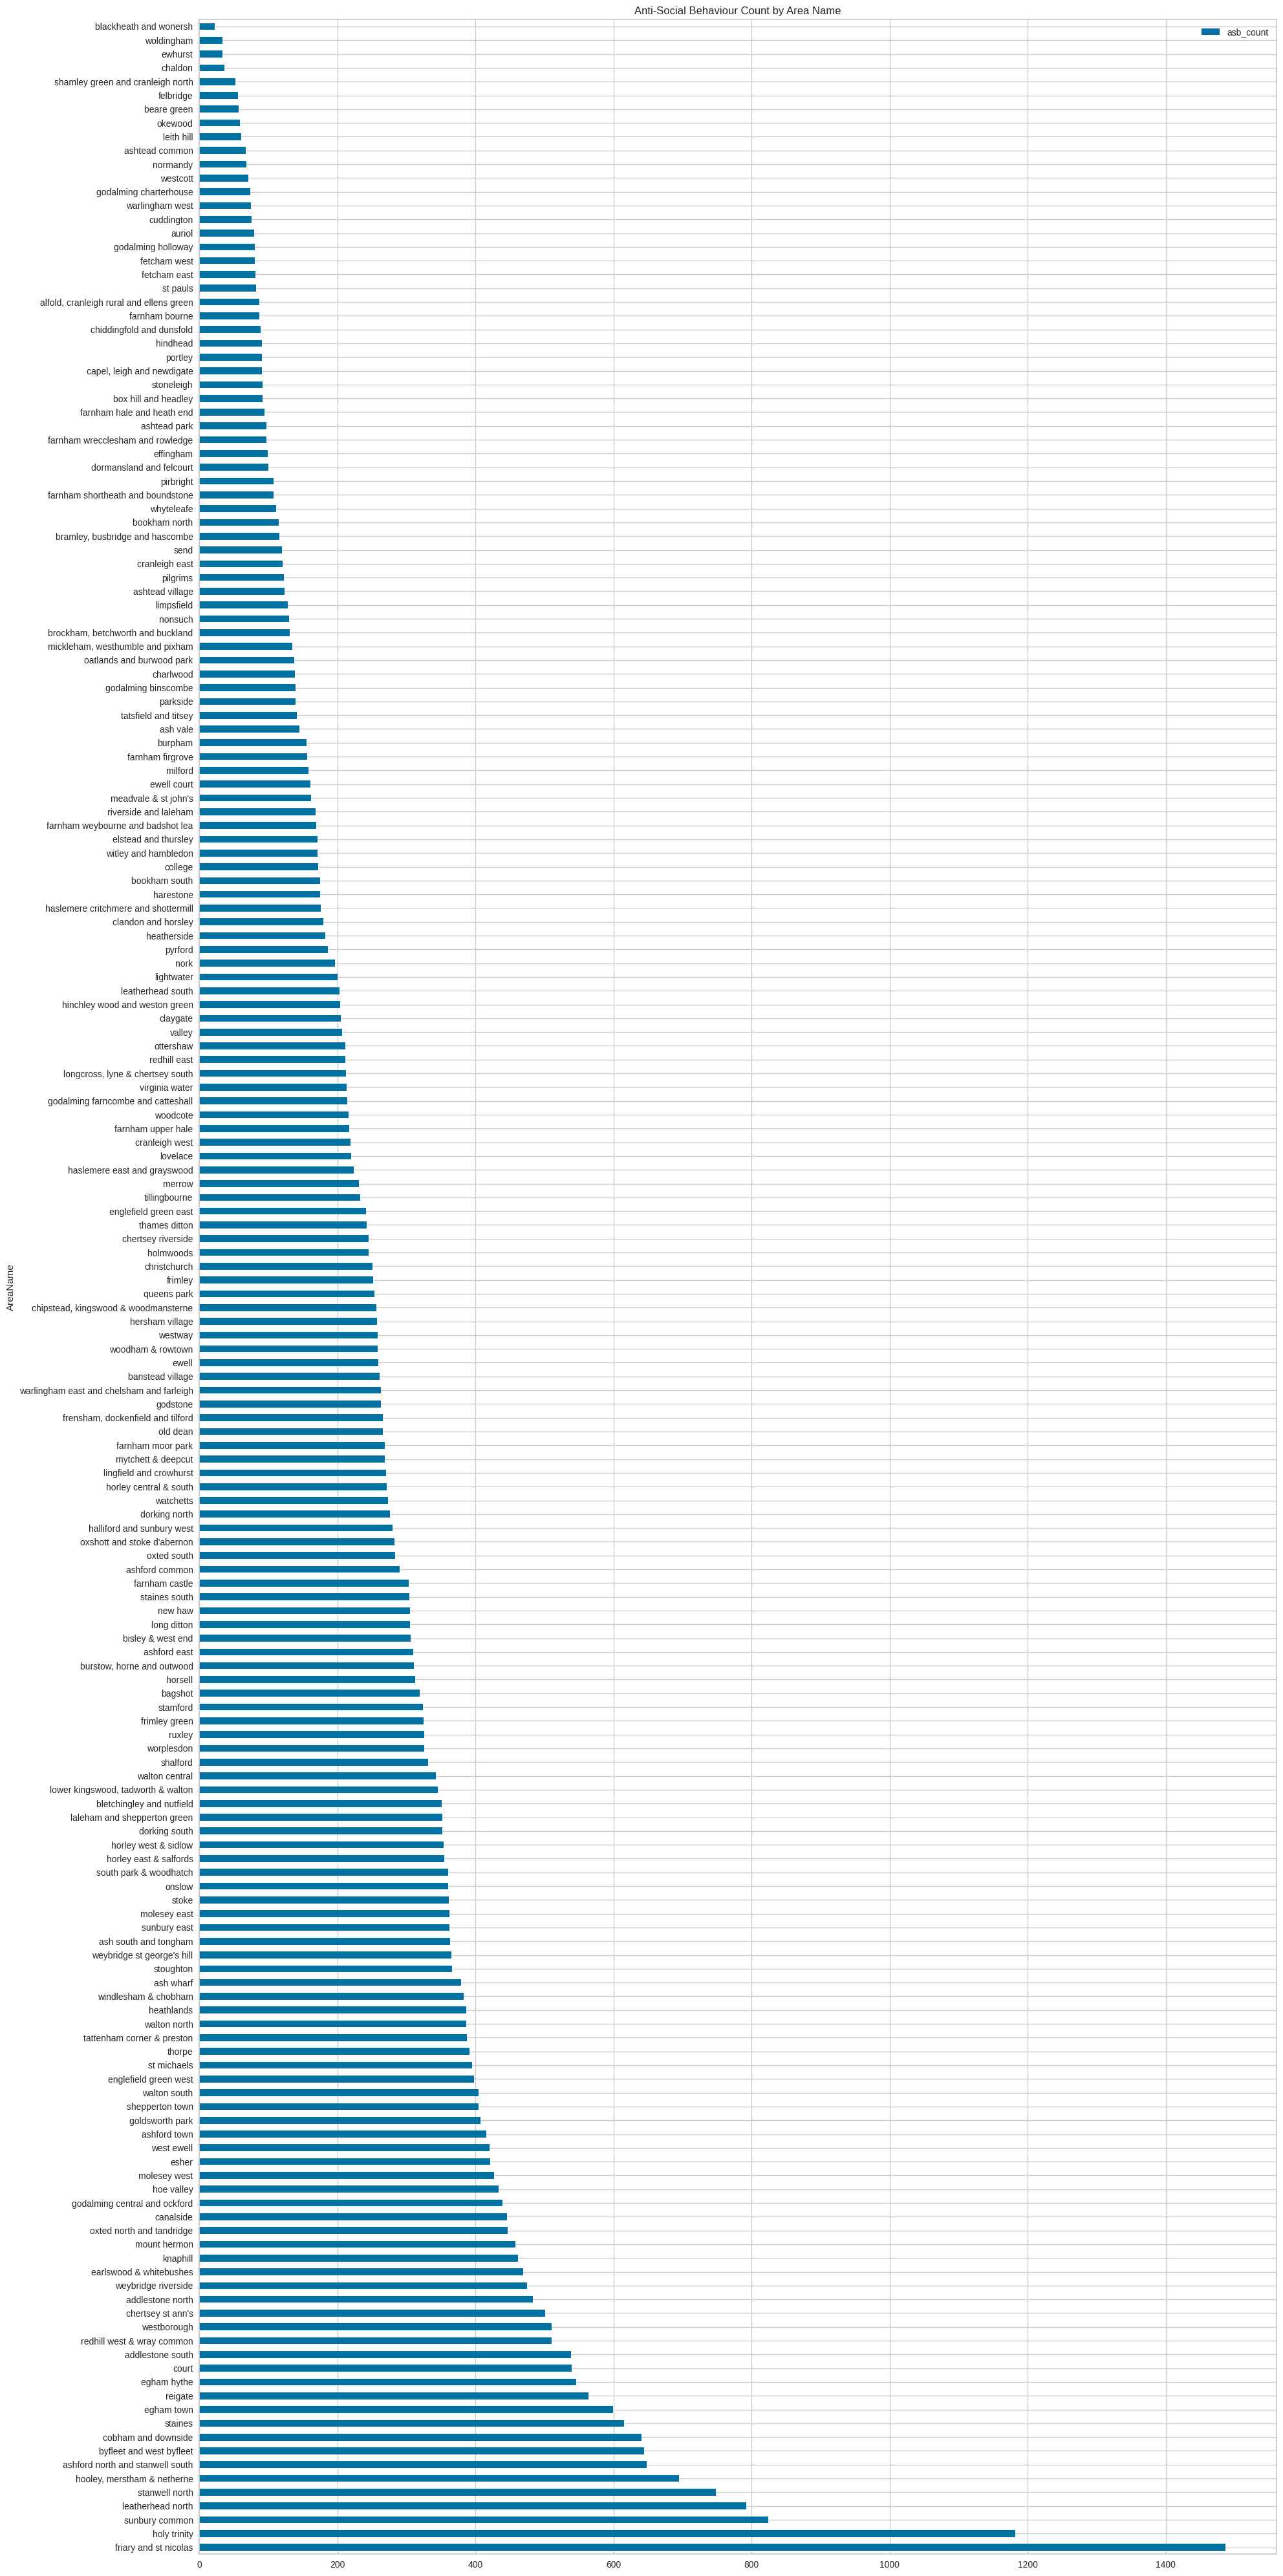

In [27]:
df_final.sort_values(
  by='asb_count', ascending=False).plot(
    kind='barh',
    x='AreaName',
    y='asb_count',
    figsize=(20, 40),
    title='Anti-Social Behaviour Count by Area Name')
plt.tight_layout()
plt.show()


In [28]:
df_final.describe()

,UnempBenefitSep23,DisabilityBenefitFeb23,PensionersPoverty,YouthUnempSep23,ChildPovertyPct,TotalPop2020,Pop0to15_2020,WorkingAgePop2020,Pop65plus_2020,WhiteEthnic2021,...,ChildLowIncomeOutOfWorkPct202122,ChildLowIncomeFamilies202122,NoCarHouseholds2021,BroadbandSpeedJul20,BelowUSOBroadbandPremises2019,GreenspacePublicParks2017,GreenspaceTotal2017,LocalElectionVoterTurnout2016to2019,FuelPovertyHouseholds2021,asb_count
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,...,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.0000
mean,2.019429,1.520455,6.103436,2.567723,19.083822,6396.255435,19.414284,60.342107,20.243609,87.096635,...,14.832549,9.081233,11.706536,74.409243,1.075348,2.223915,7.753159,36.288231,7.617765,277.0000
std,0.902917,0.545995,2.750537,2.273095,5.241546,2481.416840,3.035898,4.734574,5.080960,7.426255,...,7.592988,4.831647,5.143722,21.099230,2.428989,5.217693,7.831847,6.967220,1.757280,196.0046
min,0.309225,0.233679,1.059002,0.000000,10.077508,1763.000000,8.031233,48.085106,6.805900,51.928591,...,3.289474,0.860585,2.748691,32.627910,0.000000,0.000000,0.000000,13.783385,4.187438,22.0000
25%,1.409796,1.155370,4.110105,0.985447,15.724829,4437.250000,17.852532,57.564249,17.184292,83.448204,...,10.427296,5.804721,8.200923,53.670574,0.000000,0.000000,2.637221,31.344047,6.647524,136.5000
50%,1.870974,1.444325,5.518382,2.154461,18.422445,6212.500000,19.690704,59.694684,20.387423,87.550682,...,14.760349,8.193207,10.661345,79.430705,0.161517,0.230709,5.241408,35.841427,7.277222,253.0000
75%,2.491019,1.841175,7.853017,3.513191,21.394469,8368.000000,21.487481,61.951415,23.454114,93.467855,...,16.165330,11.704866,14.340286,90.054238,0.925926,2.272277,10.500394,40.847465,8.222744,362.0000
max,5.824885,3.436940,15.699659,12.741313,40.581384,12099.000000,26.264984,85.015335,41.829336,97.606925,...,55.263158,28.434505,30.451381,118.675802,18.035191,48.971675,52.517833,55.143437,15.712188,1486.0000


In [29]:
# Check for missing values
null_cols = df_final.isnull().sum().sort_values(ascending=False)
null_cols[null_cols > 0]

Series([], dtype: int64)

In [30]:
df_final.to_csv('data/regression_data_ward.csv', index=False)

# Modelling (Regression)

In [31]:
dataset = pd.read_csv('data/regression_data_ward.csv')
dataset.tail()

,AreaType,AreaName,UnempBenefitSep23,DisabilityBenefitFeb23,PensionersPoverty,YouthUnempSep23,ChildPovertyPct,TotalPop2020,Pop0to15_2020,WorkingAgePop2020,...,ChildLowIncomeFamilies202122,NoCarHouseholds2021,BroadbandSpeedJul20,BelowUSOBroadbandPremises2019,GreenspacePublicParks2017,GreenspaceTotal2017,LocalElectionVoterTurnout2016to2019,FuelPovertyHouseholds2021,WD22NM,asb_count
179,woking wards,hoe valley,3.639213,2.906545,10.430464,6.902655,37.786630,9427,26.264984,60.920760,...,14.398898,11.421661,91.791234,0.000000,0.710127,4.748338,28.337072,7.456311,hoe valley,433
180,woking wards,horsell,1.527828,1.489318,4.366197,0.790514,18.066900,9736,21.651602,56.470830,...,3.724030,10.552897,96.514130,0.204290,0.083488,2.368719,43.550877,6.844784,horsell,313
181,woking wards,knaphill,2.183608,2.371203,5.335844,1.948052,22.168969,10501,22.902581,61.927435,...,10.500525,10.543204,91.101595,0.000000,0.539994,13.346687,33.216169,5.312710,knaphill,462
182,woking wards,mount hermon,2.123525,1.112428,7.095209,2.635659,19.646446,10967,19.266892,65.697091,...,6.719204,24.111314,92.465048,0.000000,2.693614,24.452998,37.668828,6.225326,mount hermon,458
183,woking wards,pyrford,2.487008,1.572492,5.032823,3.204047,27.834110,9539,19.561799,56.483908,...,15.961622,9.580998,87.934931,3.569581,0.000000,26.299886,39.144471,7.262731,pyrford,186


In [32]:
# Feature selection shows that the following featuers seems to be higly corrlated with teh ASB count:
# 'TotalCrimeOffencesJun22May23': It seams that the anti-social behaviour is already included in the total crime offences.
# So, we will remove this feature.
features_to_remove = ['TotalCrimeOffencesJun22May23']
dataset = dataset[[col for col in dataset.columns if col not in features_to_remove]]
dataset.shape

(184, 64)

In [33]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 64 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   AreaType                             184 non-null    object 
 1   AreaName                             184 non-null    object 
 2   UnempBenefitSep23                    184 non-null    float64
 3   DisabilityBenefitFeb23               184 non-null    float64
 4   PensionersPoverty                    184 non-null    float64
 5   YouthUnempSep23                      184 non-null    float64
 6   ChildPovertyPct                      184 non-null    float64
 7   TotalPop2020                         184 non-null    int64  
 8   Pop0to15_2020                        184 non-null    float64
 9   WorkingAgePop2020                    184 non-null    float64
 10  Pop65plus_2020                       184 non-null    float64
 11  WhiteEthnic2021                 

In [34]:
target = 'asb_count' # Target column
columns_to_filter = ['WD22NM', 'AreaType','AreaName'] # Neumerical columns to filter out
dataset_exp = dataset.drop(columns=columns_to_filter)
dataset_exp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 61 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   UnempBenefitSep23                    184 non-null    float64
 1   DisabilityBenefitFeb23               184 non-null    float64
 2   PensionersPoverty                    184 non-null    float64
 3   YouthUnempSep23                      184 non-null    float64
 4   ChildPovertyPct                      184 non-null    float64
 5   TotalPop2020                         184 non-null    int64  
 6   Pop0to15_2020                        184 non-null    float64
 7   WorkingAgePop2020                    184 non-null    float64
 8   Pop65plus_2020                       184 non-null    float64
 9   WhiteEthnic2021                      184 non-null    float64
 10  MixedEthnic2021                      184 non-null    float64
 11  AsianEthnic2021                 

In [35]:
# Set up the experiment with session_id for reproducibility
s = setup(
  dataset_exp,
  target=target,
  session_id=123,
  use_gpu=True, # Use GPU , set it to false if you don't have GPU
  normalize=True, # Normalize data automatically
  feature_selection=True,# Perform feature selection automatically
  remove_multicollinearity=True, # Remove multicollinearity automatically to adress the issue of high correlation between features
  multicollinearity_threshold=0.7,# Set the threshold for multicollinearity this thersold needs domain knowledge to set it
  )


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves t

,Description,Value
0,Session id,123
1,Target,asb_count
2,Target type,Regression
3,Original data shape,"(184, 61)"
4,Transformed data shape,"(184, 13)"
5,Transformed train set shape,"(128, 13)"
6,Transformed test set shape,"(56, 13)"
7,Numeric features,60
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Quadro RTX 4000, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves t

In [36]:
# Perform experiment with all models
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,78.5541,16007.0079,115.2016,0.5507,0.4004,0.3295,0.0610
par,Passive Aggressive Regressor,78.8403,16808.2766,116.9745,0.5505,0.4081,0.3271,0.0750
en,Elastic Net,84.7048,17758.1097,121.2289,0.5116,0.4491,0.4432,0.0530
br,Bayesian Ridge,83.8261,17157.7225,120.8669,0.4729,0.4679,0.3755,0.0670
ada,AdaBoost Regressor,92.2446,19261.3230,127.1993,0.4710,0.4665,0.4738,0.1210
et,Extra Trees Regressor,86.0545,19461.9121,126.8741,0.4546,0.4074,0.3825,0.1400
lasso,Lasso Regression,84.9865,17180.1502,121.7101,0.4529,0.4870,0.3765,0.0680
llar,Lasso Least Angle Regression,84.9859,17180.1984,121.7096,0.4529,0.4870,0.3764,0.0880
ridge,Ridge Regression,85.7128,17384.9842,122.3898,0.4428,0.4977,0.3808,0.0640
lar,Least Angle Regression,86.0419,17430.6589,122.6479,0.4379,0.5051,0.3822,0.0550


In [37]:
print(best)

HuberRegressor()


In [38]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [39]:
tuned = tune_model(best, optimize='MAE', choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,68.6266,7157.7121,84.6033,0.4443,0.5202,0.3174
1,131.0474,70279.5317,265.1029,0.4214,0.4549,0.3887
2,72.0240,14742.1106,121.4171,0.7091,0.3528,0.3126
3,76.4953,9951.6747,99.7581,0.6089,0.4706,0.4305
4,104.6849,17570.3612,132.5532,0.4645,0.3709,0.3177
5,62.5014,5772.2109,75.9751,0.6532,0.4096,0.4013
6,64.1627,8316.8141,91.1966,0.3511,0.3707,0.3721
7,79.1485,10895.7143,104.3825,0.5140,0.3964,0.3160
8,66.9995,12552.2080,112.0366,0.6835,0.3675,0.3071


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 33
[LightGBM] [Info] Start training from score 276.956522
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.272565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 27
[LightGBM] [Info] Number of data points in the train set: 115, number of used features: 33
[LightGBM] [Info] Sta

In [40]:
s.evaluate_model(tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

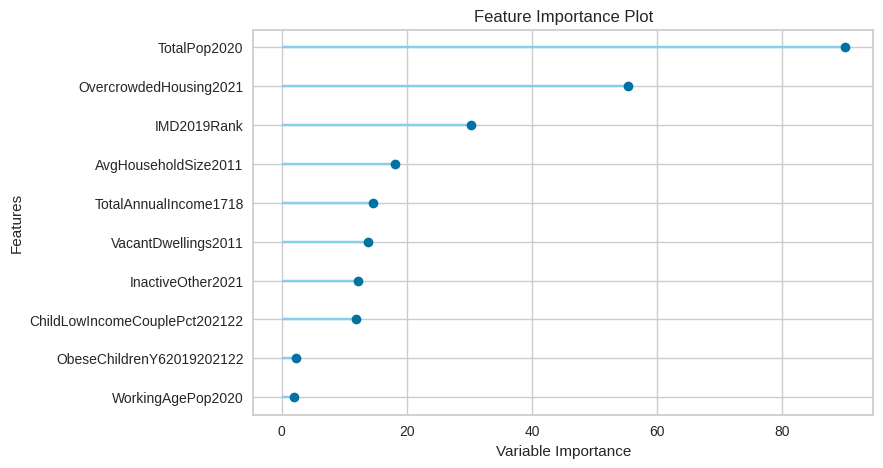

In [41]:
# Top 10 featuers
plot_model(best, plot='feature')

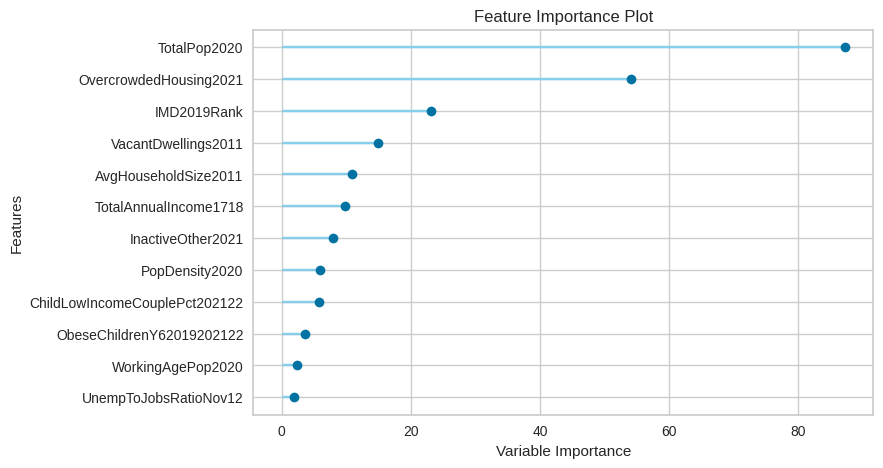

In [42]:
plot_model(tuned, plot='feature_all')

In [47]:
def get_key_by_value(dictionary, value):
    return next((key for key, val in dictionary.items() if val == value), None)


In [48]:
selected_feat = tuned.feature_names_in_
for f in selected_feat:
  print(f'{f}: {get_key_by_value(new_names, f)}')
  print("")

TotalPop2020: Total population (2020)

WorkingAgePop2020: Population of working age (16-64) (2020)

PopDensity2020: Population density (persons per hectare) (2020)

OvercrowdedHousing2021: Overcrowded housing (Census 2021)

VacantDwellings2011: Vacant Dwellings (Census 2011)

AvgHouseholdSize2011: Average household size (Census 2011)

ObeseChildrenY62019202122: Obese children in year 6 (2019/20 - 21/22)

InactiveOther2021: Economically inactive: Other (Census 2021)

UnempToJobsRatioNov12: Unemployment to available jobs ratio (Nov-12)

TotalAnnualIncome1718: Total annual household income estimate (2017/18)

IMD2019Rank: Index of Multiple Deprivation (IMD) 2019 Rank

ChildLowIncomeCouplePct202122: Children 0-19 in relative low-income couple families (as % of all in relative low income families) (2021/2022)



### Prediction

In [49]:
st_jns = df_indecators_clean[df_indecators_clean['AreaName']=="st john's"]
st_jns_data = st_jns.drop(columns=['AreaType','AreaName'])
st_jns_data

,UnempBenefitSep23,DisabilityBenefitFeb23,PensionersPoverty,YouthUnempSep23,ChildPovertyPct,TotalPop2020,Pop0to15_2020,WorkingAgePop2020,Pop65plus_2020,WhiteEthnic2021,...,ChildLowIncomeCouplePct202122,ChildLowIncomeOutOfWorkPct202122,ChildLowIncomeFamilies202122,NoCarHouseholds2021,BroadbandSpeedJul20,BelowUSOBroadbandPremises2019,GreenspacePublicParks2017,GreenspaceTotal2017,LocalElectionVoterTurnout2016to2019,FuelPovertyHouseholds2021
197,2.58894,1.876759,6.370757,5.434783,19.093074,9591,20.83203,59.201335,19.966635,83.830005,...,51.381215,6.629834,7.662997,14.413543,98.104419,0.0,1.747096,1.896225,37.866667,5.691809


In [46]:
pred = predict_model(tuned,data=st_jns_data)['prediction_label'].values[0]
print(f"prediction of asb in st johns: {pred :.0f}")

prediction of asb in st johns: 392


ToDo:
* Do some statistical analysis on teh selected features on the WARDS, Histogram, bar, map

## Statistical analysis on the important features

In [53]:
percentiles = dataset['asb_count'].quantile([0.25, 0.75])
# Define categories based on percentiles
low_threshold = percentiles[0.25]
medium_threshold = percentiles[0.75]

def categorize_asb(asb_count):
  if asb_count <= low_threshold:
    return 'Low'
  elif asb_count <= medium_threshold:
    return 'Medium'
  else:
    return 'High'

# Add a new column with ASB category
dataset['ASB Category'] = dataset['asb_count'].apply(categorize_asb)
dataset.head()

,AreaType,AreaName,UnempBenefitSep23,DisabilityBenefitFeb23,PensionersPoverty,YouthUnempSep23,ChildPovertyPct,TotalPop2020,Pop0to15_2020,WorkingAgePop2020,...,NoCarHouseholds2021,BroadbandSpeedJul20,BelowUSOBroadbandPremises2019,GreenspacePublicParks2017,GreenspaceTotal2017,LocalElectionVoterTurnout2016to2019,FuelPovertyHouseholds2021,WD22NM,asb_count,ASB Category
0,elmbridge wards,claygate,1.977967,0.998146,5.183727,0.000000,16.671953,7013,21.317553,56.951376,...,9.356101,92.168959,0.000000,0.003211,3.814245,41.556777,7.654666,claygate,205,Medium
1,elmbridge wards,cobham and downside,1.983114,1.503926,7.779419,2.296451,32.096514,9043,21.220834,56.319805,...,12.506724,79.493225,0.517879,2.373987,3.116821,30.212631,9.071674,cobham and downside,640,High
2,elmbridge wards,esher,2.075204,1.307190,5.772402,2.622951,24.072676,9486,21.389416,59.434957,...,9.899610,85.752733,0.406814,2.266658,9.905930,37.557746,8.028017,esher,421,High
3,elmbridge wards,hersham village,2.318959,1.457346,9.154930,4.473684,20.462943,8440,24.928910,58.246446,...,12.428455,95.038102,0.000000,0.878644,15.083548,35.337034,7.075472,hersham village,257,Medium
4,elmbridge wards,hinchley wood and weston green,1.138088,0.814440,2.798507,1.996008,21.326343,9086,24.279111,58.023333,...,7.517372,99.675791,0.120084,6.512984,18.922664,37.868982,7.438531,hinchley wood and weston green,204,Medium


In [55]:
low_threshold

136.5

In [54]:
dataset.to_csv('data/regression_data_ward_categorized.csv', index=False)